## Imports and Data

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

england_matches = pd.read_json('new_data/matches/matches_England.json')
teams = pd.read_json('new_data/teams.json')
england_events = pd.read_json('new_data/events/events_England.json')
players = pd.read_json('new_data/players.json')

## Team Analysis
### Team class for accessing team attributes (id, matches, players, events etc.) 


In [88]:
class team:
    def __init__(self, name:str):
        self.name = name
        self.team_id = self.get_team_id()
        self.matches = self.get_matches()
        self.players = self.get_players()
        self.all_events = self.get_all_events()
    
    def get_team_id(self):
        return int(teams[teams['name'] == self.name]['wyId'])
        
    def get_matches(self, opposition_team=None):
        matches = pd.DataFrame(columns=england_matches.columns)
        specific_matches = pd.DataFrame(columns=england_matches.columns)
        
        for index,row in england_matches.iterrows():
            teams_in_match = [int(team) for team in list(row['teamsData'].keys())]
            if opposition_team is None:
                if self.team_id in teams_in_match:
                    matches = matches.append(row)
            else:
                if self.team_id in teams_in_match and opposition_team.team_id in teams_in_match:
                    specific_matches = specific_matches.append(row)
                
        if opposition_team is None:     
            return matches
        else:
            return specific_matches
    
    def get_players(self):
        return players[players['currentTeamId'] == self.team_id]
    
    def get_all_events(self):
        return england_events[england_events['teamId'] == self.team_id]

## Arsenal Leicester Match Analysis

In [4]:
arsenal = team('Arsenal')
leicester = team('Leicester City')

afc_lcfc = arsenal.get_matches(leicester.team_id).iloc[1]
afc_lcfc_id = afc_lcfc['wyId']

afc_lcfc_events = arsenal.all_events[arsenal.all_events['matchId'] == afc_lcfc_id]
afc_lcfc_passes = afc_lcfc_events[afc_lcfc_events['eventName'] == 'Pass']

afc_lcfc_passes['x_start'] = afc_lcfc_passes.apply(lambda row: row['positions'][0]['x'], axis=1)
afc_lcfc_passes['y_start'] = afc_lcfc_passes.apply(lambda row: row['positions'][0]['y'], axis=1)

# afc_lcfc_passes

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


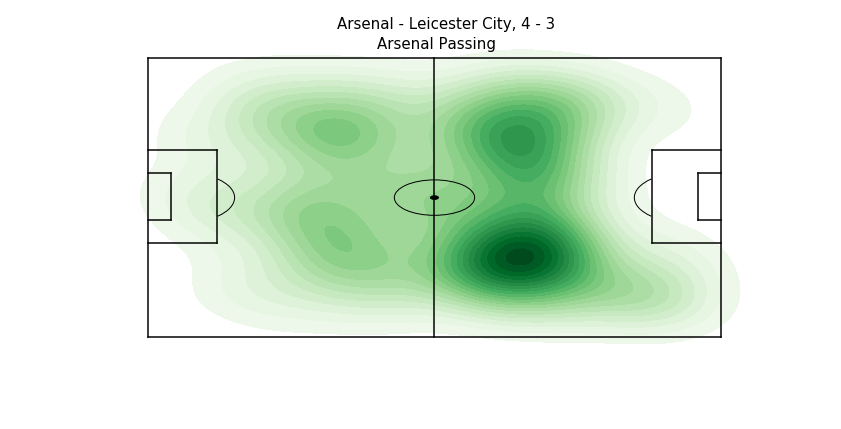

In [5]:
from matplotlib.patches import Arc

fig = plt.figure()
fig.set_size_inches(14,7)

ax = plt.subplot(111)

def draw_pitch():
    global fig,axes
    
    #touchline
    plt.plot([0,0], [-5,105], 'k') #left length
    plt.plot([0,100], [105,105], 'k') #upper width
    plt.plot([100,100], [-5,105], 'k') #right length
    plt.plot([100,0], [-5,-5], 'k') #lower width
    plt.plot([50,50], [-5,105], 'k') #halfway line

    #center
    center_circle = plt.Circle((50,50), radius=7, color='black', fill=False)
    center_spot = plt.Circle((50,50), radius=0.7, color='black', fill=True)
    ax.add_artist(center_circle)
    ax.add_artist(center_spot)

    #left 18 yard box
    plt.plot([0,12], [32,32], 'k')
    plt.plot([0,12], [69,69], 'k')
    plt.plot([12,12], [32,69], 'k')
    left_d = Arc((6, 50), width=18.3, height=20, theta1=310, theta2=50, color='black')
    ax.add_patch(left_d)

    #left 6 yard box
    plt.plot([0,4], [41.25,41.25], 'k')
    plt.plot([0,4], [59.75,59.75], 'k')
    plt.plot([4,4], [59.75,41.25], 'k')

    #right 18 yard box
    plt.plot([100,88], [32,32], 'k')
    plt.plot([100,88], [69,69], 'k')
    plt.plot([88,88], [32,69], 'k')
    right_d = Arc((94, 50), width=18.3, height=20, theta1=130, theta2=230, color='black')
    ax.add_patch(right_d)

    #right 6 yard box
    plt.plot([100,96], [41.25,41.25], 'k')
    plt.plot([100,96], [59.75,59.75], 'k')
    plt.plot([96,96], [59.75,41.25], 'k')

#dataframe should be an 'events' dataframe
def draw_heatmap(dataframe):
    sns.kdeplot(dataframe['x_start'], dataframe['y_start'], shade=True, shade_lowest=False, cmap='Greens', n_levels = 30)
    plt.xlim, plt.ylim = (0,100), (0,100)

    plt.axis('off')
    plt.show()
    
draw_pitch()
plt.text(33, 117, afc_lcfc.label, fontdict={'size':15})
plt.text(40, 109, "Arsenal Passing", fontdict={'size':15})
draw_heatmap(afc_lcfc_passes)

In [152]:
from ipywidgets import interact, interactive, interact_manual

team_selector_options = ['Arsenal', 'Leicester City']

matches = None
target_match = None

team_1_selector = widgets.Dropdown(options=team_selector_options, description='Team 1:')
team_2_selector = widgets.Dropdown(options=team_selector_options, description='Team 2:')

def select_teams(team_1_selector, team_2_selector):
    global matches
    
    team_1 = team(team_1_selector)
    team_2 = team(team_2_selector)
    matches = team_1.get_matches(team_2)
    
    match_selector = interact(select_match, match_selector=matches['label'].tolist())
    
def select_match(match_selector) -> pd.DataFrame:
    global matches, target_match
    
    target_match = matches[matches['label'] == match_selector]
    display(target_match)
    target_team_selector = interact_manual(select_team, team_selector=team_selector_options)

def select_team(team_selector):
    global target_match
    
    target_team = team_1 if team_selector == team_1.name else team_2
    events = target_team.all_events[target_team.all_events['matchId'] == int(target_match['wyId'])]
    passes = events[events['eventName'] == 'Pass']
    passes['x_start'] = passes.apply(lambda row: row['positions'][0]['x'], axis=1)
    passes['y_start'] = passes.apply(lambda row: row['positions'][0]['y'], axis=1)
    
    draw_pitch()
    draw_heatmap(passes)

    
interact_manual(select_teams, team_1_selector=team_1_selector, team_2_selector=team_2_selector)

interactive(children=(Dropdown(description='Team 1:', options=('Arsenal', 'Leicester City'), value='Arsenal'),…

<function __main__.select_teams(team_1_selector, team_2_selector)>